In [ ]:
# Loading The Simulated Data From External Repository.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [ ]:
# One-hot Encode The Simulated Dna Sequences, & Example Of One-hot Encoded Sequence Looks Like:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Loading Labels:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [ ]:
 # Spliting The Data Into Training & Test Sets
 from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [ ]:
# Dimensionality & Number Of Parameters For Each Layer In Our Network.
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12,
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,226 (24.32 KB)

 Trainable params: 6,226 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

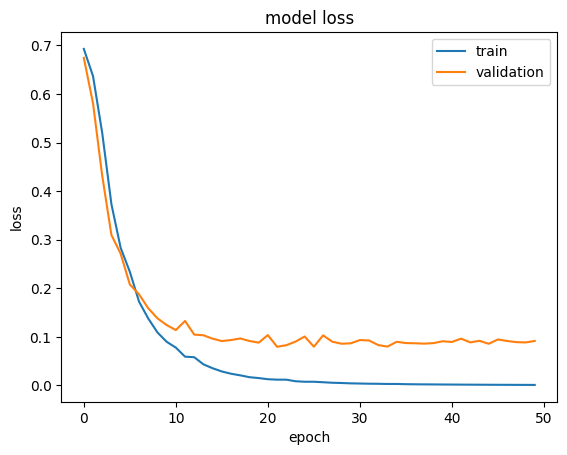

In [ ]:
# Further Divide The Training Set Into A Training And Validation Set
history = model.fit(train_features, train_labels,
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

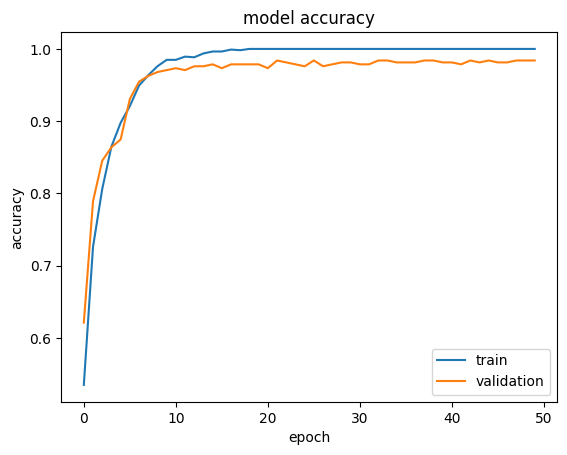

In [ ]:
 # Plot The Accuracy Of Our Neural Network On The Binary Classification Task.
 plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Confusion matrix:
 [[255   4]
 [  1 240]]


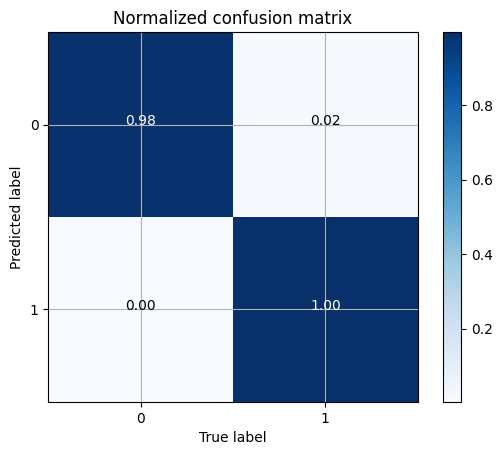

In [ ]:
# Evaluate The Model On The Test Set And Plot The Results As A Confusion Matrix.
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1),
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [24]:
import tensorflow.keras.backend as K
import tensorflow as tf

def compute_salient_bases(model, x):
    # Ensure the input tensor has the correct shape for the model
    input_tensor = tf.expand_dims(x, axis=0) # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(input_tensor) # Watch the input tensor
        # Call the model inside the tape context
        predictions = model(input_tensor)
        # We are interested in the gradient of the second output (index 1) with respect to the input
        loss = predictions[0][1]

    # Compute gradients of the loss with respect to the input tensor
    gradients = tape.gradient(loss, input_tensor)

    # Reshape gradients to match the original input shape
    gradients = tf.squeeze(gradients, axis=0)

    # Calculate saliency: element-wise product of gradients and input, then sum across the one-hot dimension
    sal = np.clip(np.sum(np.multiply(gradients, x), axis=1), a_min=0, a_max=None)
    return sal

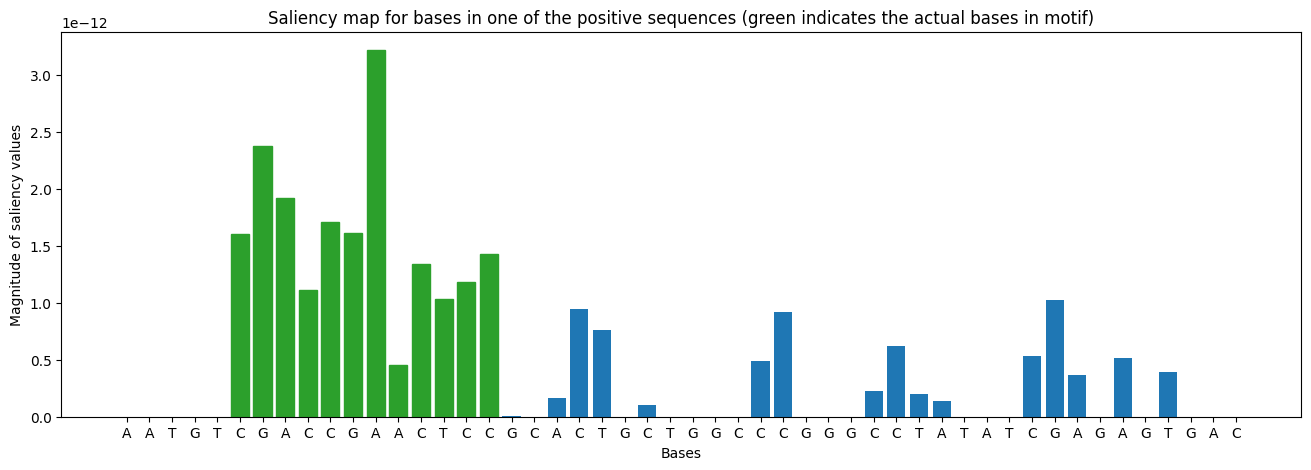

In [ ]:
# Sailency Map
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C2') for i in range(5,17)]  # Change the coloring here if you change the sequence index. # Changed to 'C2' for green
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

### Interpreting the Saliency Map

The saliency map you see above visualizes the importance of each nucleotide base in the input sequence for the model's prediction. The height of each bar corresponds to the "saliency" value, which is derived from the gradient of the model's output with respect to the input base.

*   **Higher bars** indicate that the corresponding base had a greater influence on the model's decision.
*   The **green bars** specifically highlight the region in the sequence that contains the actual known motif.

By examining where the high saliency values occur in relation to the green bars, we can infer how well the model has learned to identify the relevant motif for making its predictions. If the high bars align with or are concentrated around the green region, it suggests the model is focusing on the correct parts of the sequence.

### Discussion of Overall Findings

Based on the analysis performed:

1.  **Data Loading and Preprocessing**: We successfully loaded DNA sequences and their corresponding labels, and then preprocessed them using one-hot encoding, which is a standard technique for representing categorical data like DNA sequences for machine learning models.
2.  **Model Training**: We built and trained a 1D Convolutional Neural Network (CNN) model, which is well-suited for sequence data. The training and validation loss and accuracy plots show how the model performed during training. Ideally, we look for the training and validation curves to converge, indicating the model is learning well without significant overfitting.
3.  **Model Evaluation**: The confusion matrix provides a clear picture of the model's performance on the unseen test data. The values in the matrix show the counts of true positives, true negatives, false positives, and false negatives, allowing us to calculate metrics like accuracy, precision, and recall if needed. The normalized confusion matrix helps to understand the proportion of correct and incorrect classifications for each class.
4.  **Saliency Map Analysis**: The saliency map provides insight into which parts of the input sequences are most important for the model's predictions. By visualizing the saliency values, we can gain some interpretability into the black box of the neural network and see if the model is attending to biologically relevant regions, such as known motifs.

Overall, this analysis demonstrates a typical workflow for building and evaluating a deep learning model for a genomics task, along with a method for gaining some interpretability of the model's decisions using saliency maps.